# Variogram analysis and kriging for data in 3D (omni-directional)

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)
geone version: 1.1.1


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 3D (class `geone.covModel.CovModel3D`, see jupyter notebook `ex_grf_3d`).

In [4]:
cov_model_ref = gn.covModel.CovModel3D(elem=[
    ('spherical', {'w':9.5, 'r':[15, 15, 15]}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], alpha=0.0, beta=0.0, gamma=0.0, name='ref model (isotropic)')

In [5]:
cov_model_ref

Covariance model 3D: (Name = ref model (isotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [15, 15, 15]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angles: alpha = 0.0 deg., beta = 0.0 deg., gamma = 0.0 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
         Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''

Generate a gaussian random field in 3D (see function `geone.grf.grf3D`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [6]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
dx, dy, dz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf3D(cov_model_ref, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), nreal=1, printInfo=False) 
    # 4d-array of shape 1 x nz x ny x nx

# Extract n points from the reference simulation
n = 150 # number of data points
ind = np.random.choice(nx*ny*nz, size=n, replace=False) # indexes of extracted grid cells
iz = ind//(nx*ny) # indexes along z-axis
ii = ind%(nx*ny)
iy = ii//nx # indexes along y-axis
ix = ii%nx  # indexes along x-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
zc = oz + (iz + 0.5)*dz # z-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)
#zc = oz + (ind + np.random.random(n))*dz # z-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc, zc)).T # array of coordinates of data points (shape: n x 3)
v = ref[0].reshape(-1)[ind] # value at data points

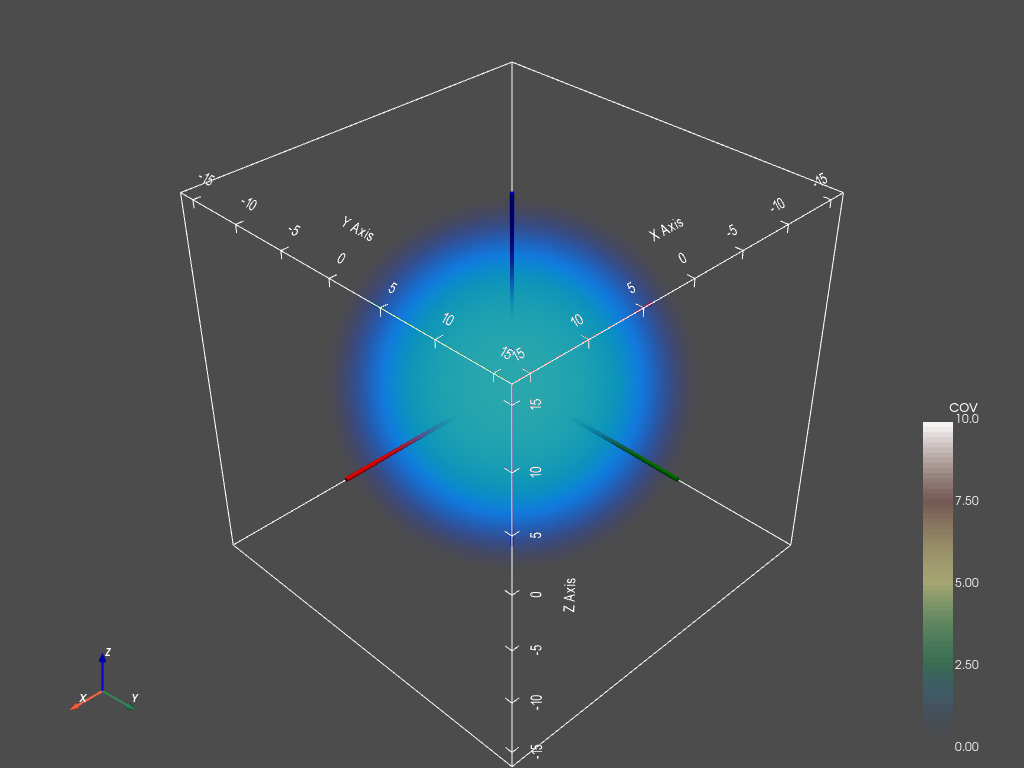

In [7]:
# Plot covariance model in 3D
cov_model_ref.plot_model3d_volume()

In [8]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Plot covariance model in 3D in an interactive figure
pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model_ref.plot_model3d_volume(plotter=pp)
pp.show() # show the figure: after closing the pop-up window, the position of the camera is retrieved in output.

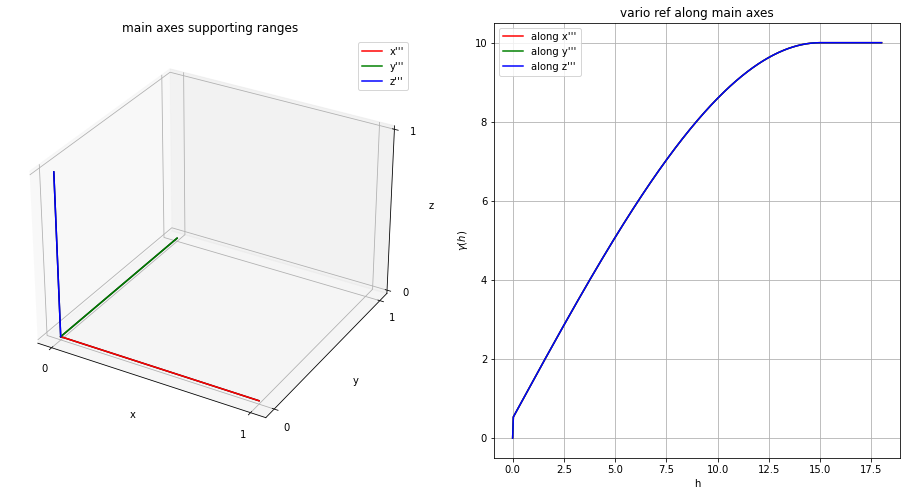

In [9]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axis
fig.add_subplot(1,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('vario ref along main axes')
plt.show()

In [10]:
# Preparation for plotting reference simulation and data points

# fill image (Img class from geone.img) for view
im_ref = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=ref)

# data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

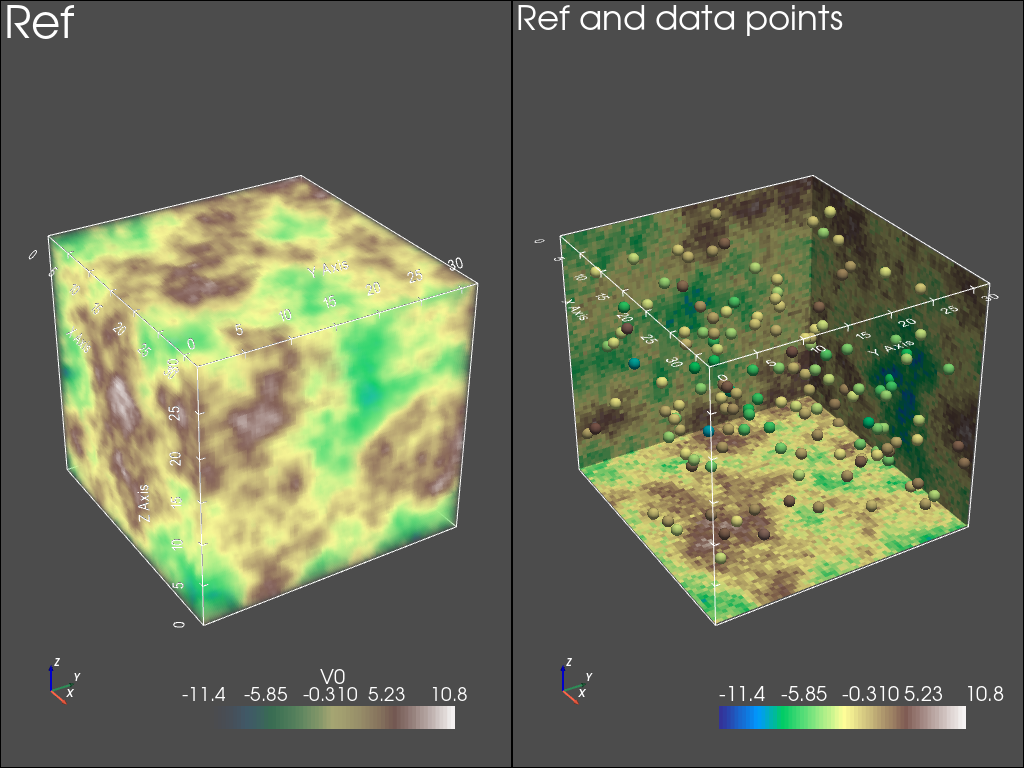

In [11]:
# Plot reference simulation and data points 

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                                show_bounds=True, # show axes and ticks around the 3D box
                                text='Ref') # title
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                               slice_normal_x=ox+0.5*dx,
                               slice_normal_y=oy+(ny-0.5)*dy,
                               slice_normal_z=oz+0.5*dz,
                               show_bounds=True, # show axes and ticks around the 3D box
                               scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
                               text='Ref and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Start from a data set in 3D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

In [12]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

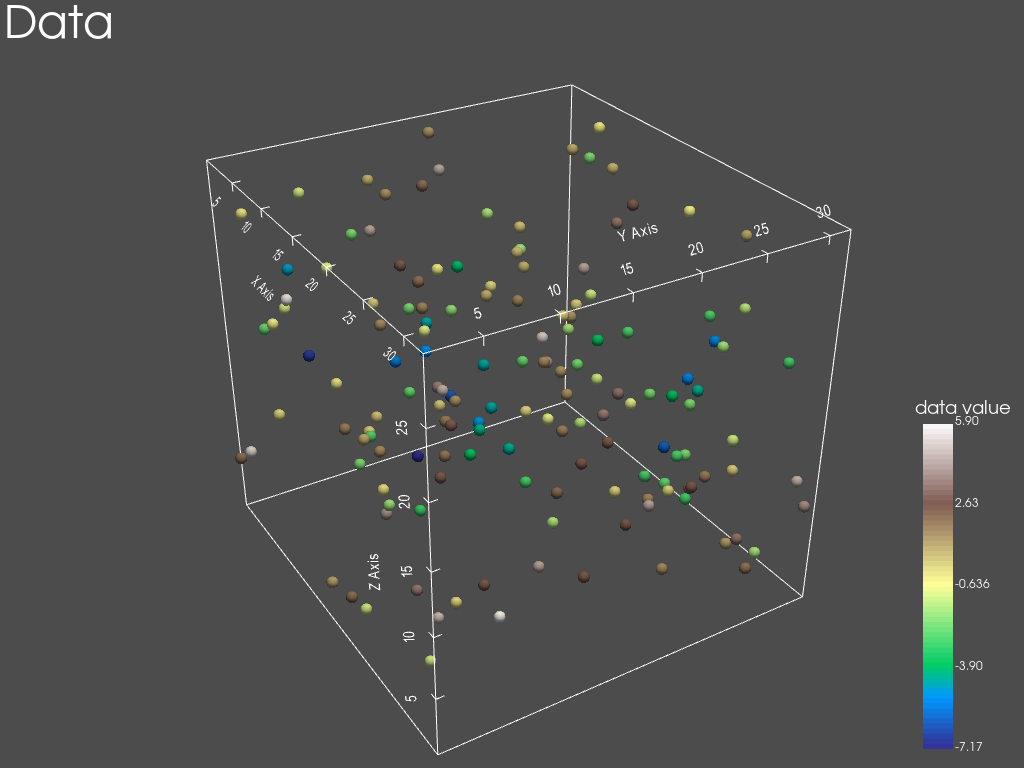

In [13]:
# Plot data points in 3D

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

pp.add_mesh(data_points, cmap='terrain', point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

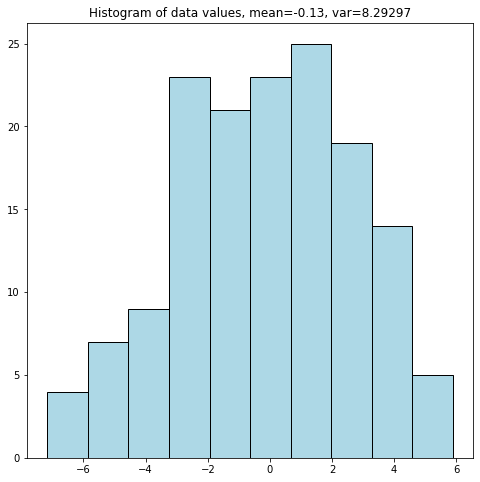

In [14]:
# Plot histogram of data values
plt.figure(figsize=(8,8))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

In the following steps, one assumes that the bi-point statistics is omni-directional (same in any direction), then omni-directional analysis is done.

### Omni-directional  variogram cloud
The function `geone.covModel.variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

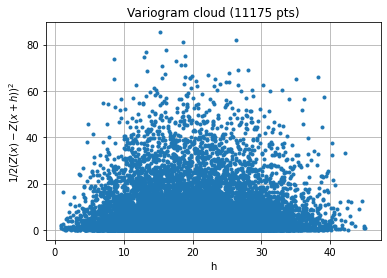

In [15]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)
plt.show()

### Omni-directional experimental variogram
The function `geone.covModel.variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

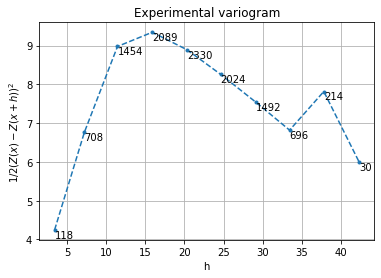

In [16]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

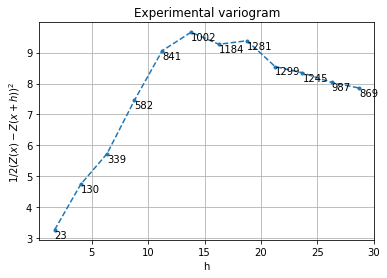

In [17]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=30, ncla=12)
plt.show()

### Omni-directional model fitting
The function `geone.covModel.covModel1D_fit` is used to fit a covariance model in 1D (class `geone.covModel.CovModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

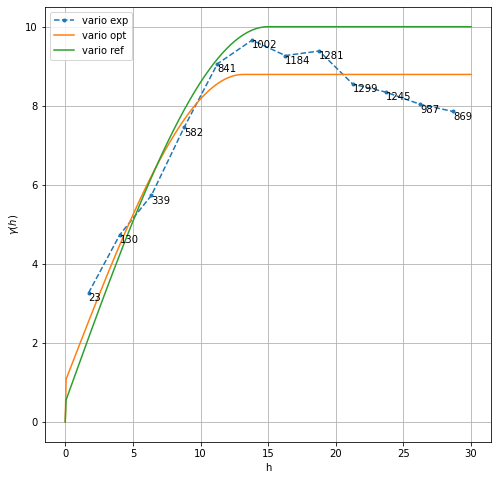

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 2.1934512201867004e-07,  r = 4.024925952330314
   Elementary contribution 1: type : spherical
      parameters:  w = 7.764712095193254,  r = 13.166442383758005
   Elementary contribution 2: type : exponential
      parameters:  w = 0.00012530707506698465,  r = 0.5496987325629308
   Elementary contribution 3: type : nugget
      parameters:  w = 1.0273224319227046

In [18]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, hmax=30,
                                         bounds=([ 0,   0, 0,  0,  0,  0,  0],  # min value for param. to fit
                                                 [20, 30, 20, 30, 30, 30, 20]), # max value for param. to fit
                                         make_plot=False)
plt.figure(figsize=(8,8))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=30, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model_one_curve(vario=True, hmax=30, label='vario ref') # cov. model in 2D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

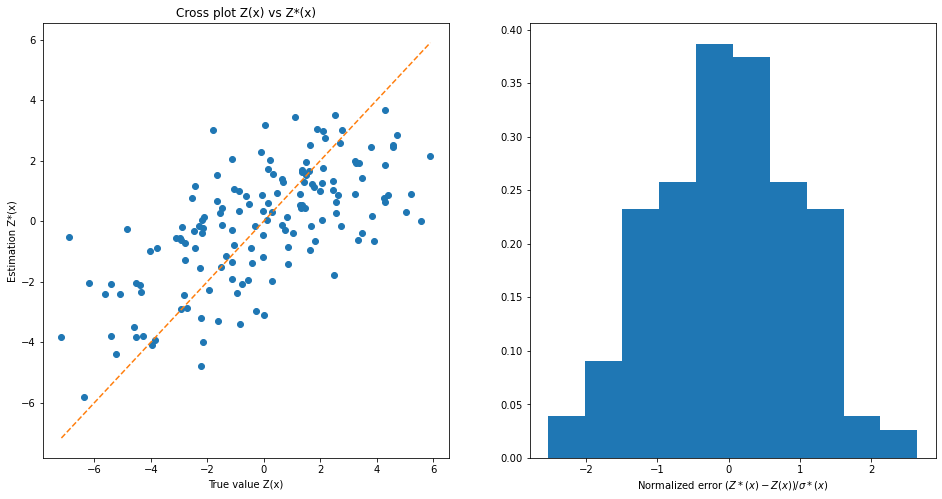

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [19]:
# Interpolation by simple kriging
cv_est1, cv_std1, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                                       #interpolator_kwargs={'mean':np.mean(v)},
                                                                       make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

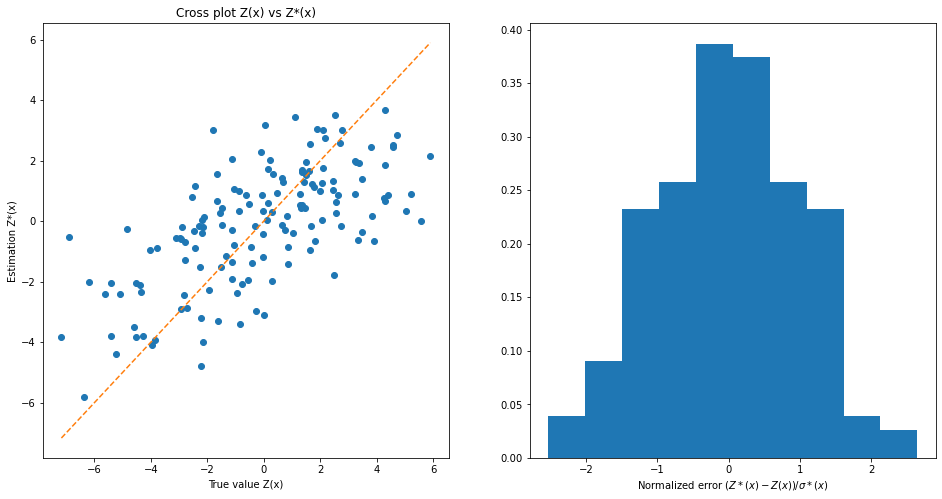

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [20]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                interpolator_kwargs={'method':'ordinary_kriging'},
                                                make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

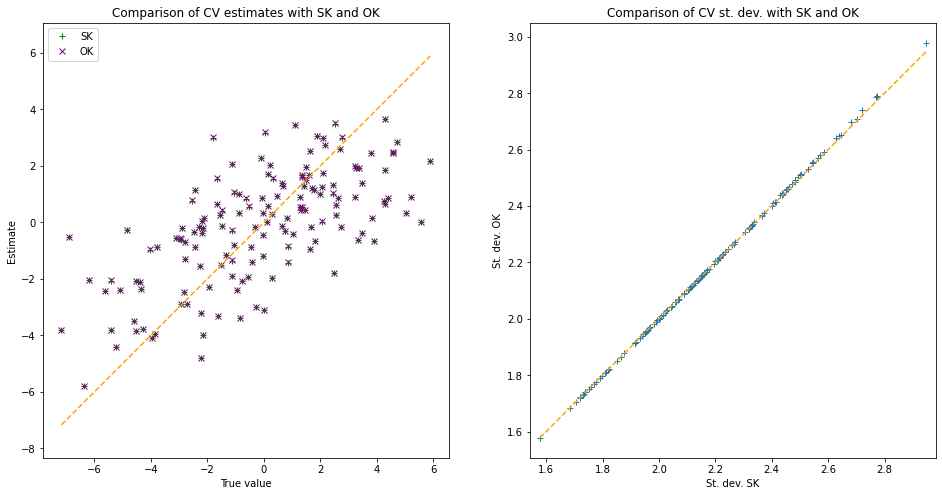

In [21]:
# Comparison of cross-validation with simple kriging and ordinary kriging
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('True value')
plt.ylabel('Estimate')
plt.legend()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued.

### Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
The function `geone.covModel.krige(x, v, xu, cov_model, method='simple_kriging', mean=None)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:
- `method='simple_kriging'` (default): simple kriging is used, with the mean automatically set to the mean of the data values (`mean=None`); a specified mean value or array (for non-stationary mean) can be set manually with the keyword argument `mean`.
- `method='ordinary_kriging'`: ordinary kriging is used (the keyword argument `mean` must be `None` in this case)

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

For data in 3D:
- `x`: 2-dimensional array of shape `(n, 3)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 3)`, location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`.

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).

In [22]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Simple kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

In [23]:
# Preparation for plot...
# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

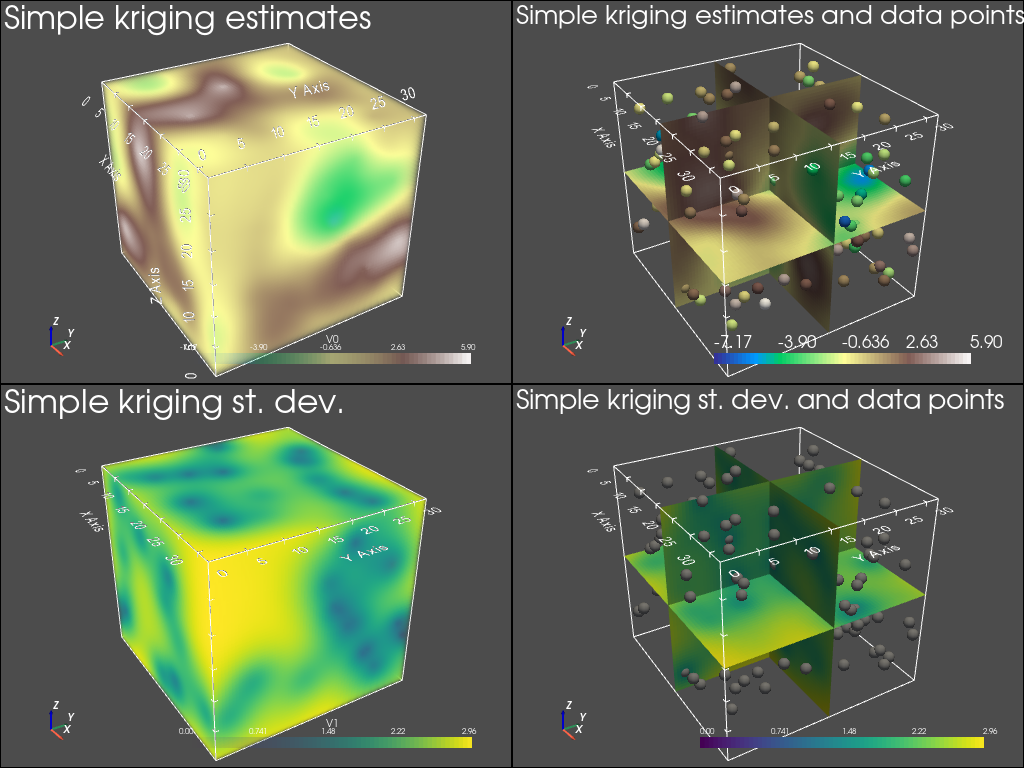

In [24]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                                show_bounds=True, # show axes and ticks around the 3D box
                                text='Simple kriging estimates') # title
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               show_bounds=True, # show axes and ticks around the 3D box
                               scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
                               text='Simple kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                                show_bounds=True, # show axes and ticks around the 3D box
                                text='Simple kriging st. dev.') # title
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               show_bounds=True, # show axes and ticks around the 3D box
                               scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
                               text='Simple kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [25]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Ordinary kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

In [26]:
# Preparation for plot...
# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

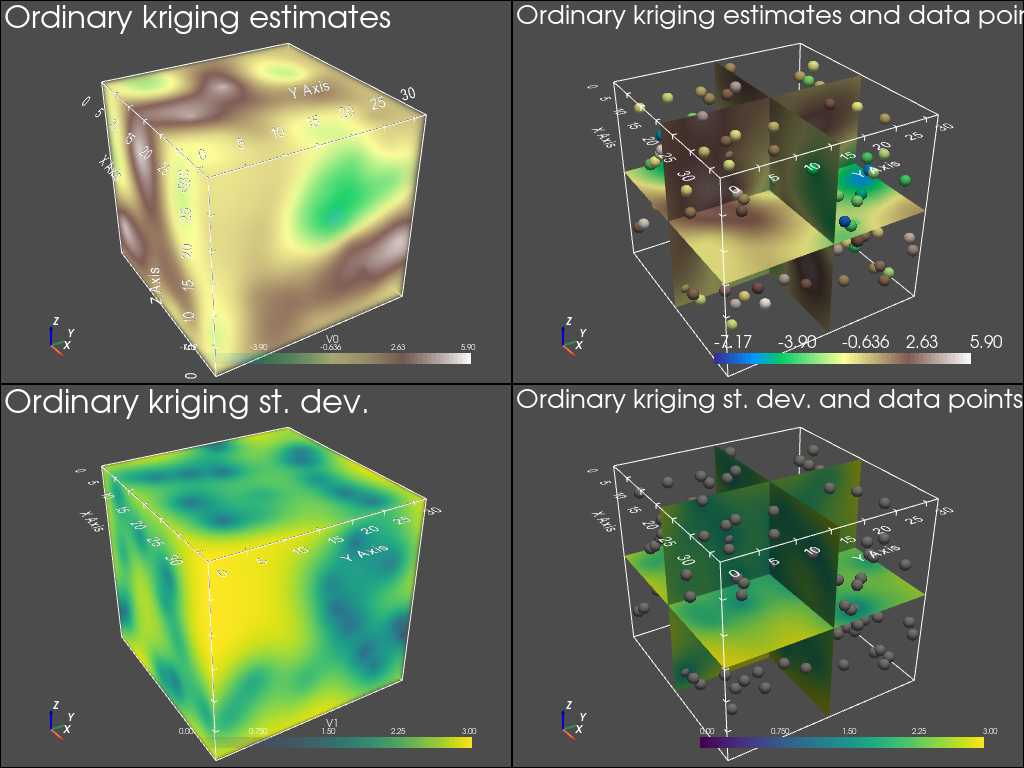

In [27]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                                show_bounds=True, # show axes and ticks around the 3D box
                                text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               show_bounds=True, # show axes and ticks around the 3D box
                               scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
                               text='Ordinary kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                                show_bounds=True, # show axes and ticks around the 3D box
                                text='Ordinary kriging st. dev.') # title
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               show_bounds=True, # show axes and ticks around the 3D box
                               scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
                               text='Ordinary kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Simulation based on simple or ordinary kriging: function `geone.covModel.sgs`
The function `geone.covModel.sgs(x, v, xu, cov_model, method='simple_kriging', mean=None, nreal=1)` performs sequential gaussian simulation (SGS) based on simple or ordinary kriging, it returns realizations at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Simulation used a *full neighorhood*, i.e. all data points and all previously simulated points are taken into account to solve the kriging system for simulating the value at a point, which is drawn in a normal law of mean equal to the kriged value and variance equal to the kriging variance. Type of kriging is determined by the keyword argument `method` as for the function `geone.covModel.krige` (see above).

For data in 3D:
- `x`: 2-dimensional array of shape `(n, 3)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 3)`, location of points where the simulation is done.

In return:
- `vu`: 2-dimensional array of shape `(nreal, m)`, each row is a realization of the simulated values at `xu`.

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).

**Important notes:**
- as a full neighborhood is used, this function should be used with a **small** set of simulated points
- this function can be slow, for faster simulations (in a grid) see the alternatives below

No example shown here (see jupyter notebook `ex_vario_analysis_data[12]D*`).

## Alternatives for kriging estimation and simulation
The module `geone.geosclassicinterface` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_3d` for 3D case):
- function `geone.geosclassicinterface.estimate3D`: estimation in a 3D grid, *i.e.* kriging estimates and standard deviation, for simple or ordinary kriging
- function `geone.geosclassicinterface.simulate3D`: simulation in a 3D grid, based on simple or ordinary kriging; allows also to handle inequality data

The module `geone.grf` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_3d` for 3D case):
- function `geone.grf.krige3D`: estimation a 3D grid, *i.e.* kriging estimates and standard deviation, for simple kriging only
- function `geone.grf.grf3D`: simulation a 3D grid, based on simple kriging only

Note that for these functions, the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

As these functions require a covariance model in 3D (class `geone.covModel.CovModel3D`), the omni-directional covariance model considered (model in 1D) must be converted first.

### Wrapper

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments  
- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D`,
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`,
- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`,
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`,

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:
- `output_mode='array'`: an numpy array is returned,
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned.

In [28]:
cov_model_opt3D = gn.covModel.covModel1D_to_covModel3D(cov_model_opt) # convert model 1D in 3D

### Estimation using the function `geone.covModel.krige`

In [29]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 4.386022329330444


### Estimation using the function `geone.grf.krige3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [30]:
t1 = time.time()
im_grf = gn.multiGaussian.multiGaussianRun(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
                                           mode='estimation', algo='fft', output_mode='img',
                                           printInfo=False)
# # Or:
# vu_grf, vu_std_grf = gn.grf.krige3D(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
#                                     printInfo=False)
# im_grf = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu_grf, vu_std_grf)))
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 2.9746291637420654


### Estimation using the function `geone.geosclassicinterface.estimate3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [31]:
t1 = time.time()
im_gci = gn.multiGaussian.multiGaussianRun(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
                                           mode='estimation', algo='classic', output_mode='img',
                                           method='simple_kriging', nneighborMax=24)
# # Or:
# estim_gci = gn.geosclassicinterface.estimate3D(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
#                                                method='simple_kriging', nneighborMax=24)
# im_gci = estim_gci['image']
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 23.30310821533203


### Plot results of estimation

In [32]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

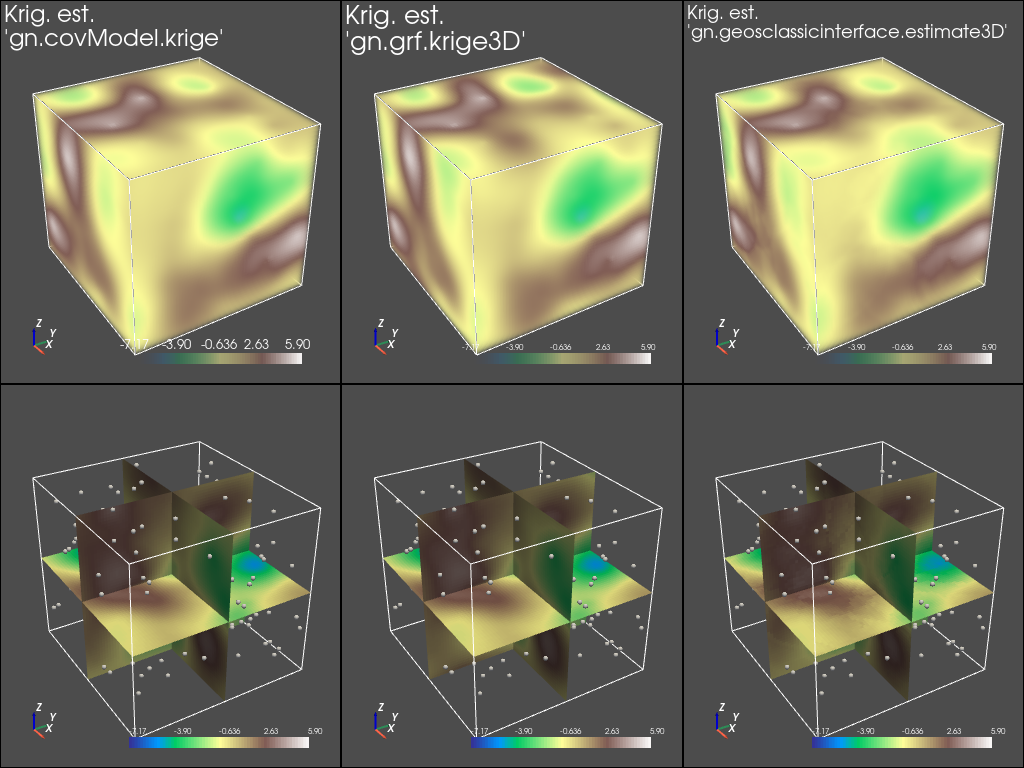

In [33]:
# Plot kriging estimates

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':''}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. est.\n'gn.covModel.krige'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(im_grf, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':' '}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. est.\n'gn.grf.krige3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(im_gci, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':'  '}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. est.\n'gn.geosclassicinterface.estimate3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'   '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(im_grf, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'    '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(im_gci, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'     '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

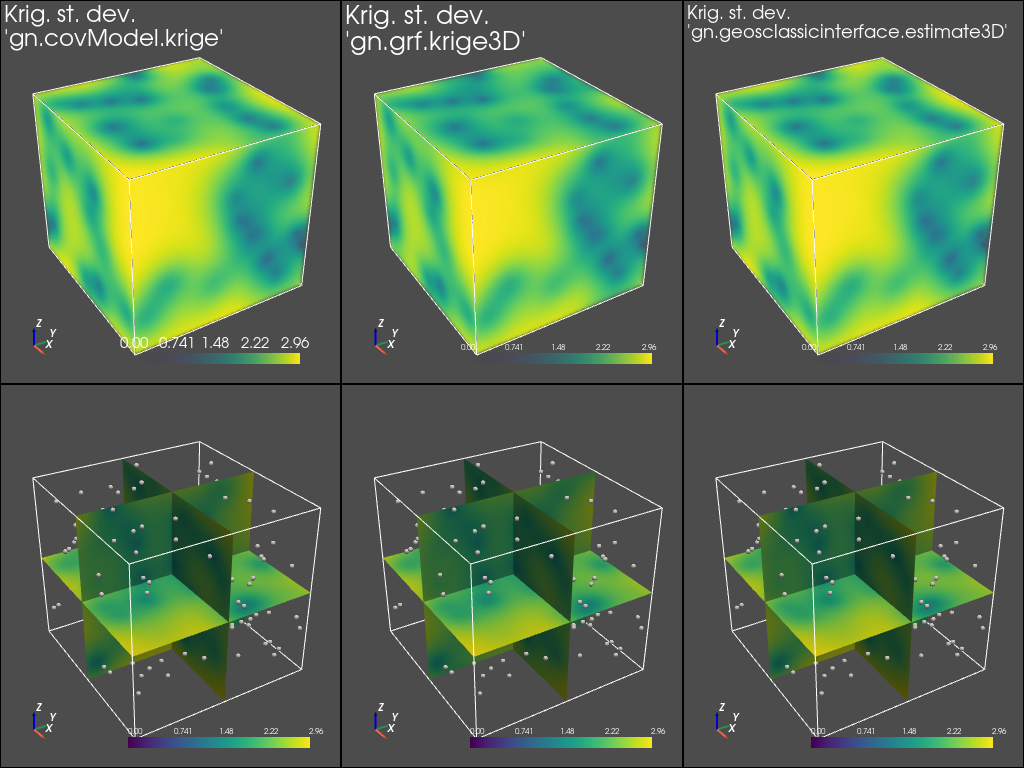

In [34]:
# Plot kriging standard deviation

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_krig, iv=1, plotter=pp, cmap='viridis',
                                scalar_bar_kwargs={'title':''}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. st. dev.\n'gn.covModel.krige'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(im_grf, iv=1, plotter=pp, cmap='viridis',
                                scalar_bar_kwargs={'title':' '}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. st. dev.\n'gn.grf.krige3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(im_gci, iv=1, plotter=pp, cmap='viridis',
                                scalar_bar_kwargs={'title':'  '}, 
                                    # distinct title in each subplot for correct display!
                                text="Krig. st. dev.\n'gn.geosclassicinterface.estimate3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(im_krig, iv=1, plotter=pp, cmap='viridis',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'   '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(im_grf, iv=1, plotter=pp, cmap='viridis',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'    '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(im_gci, iv=1, plotter=pp, cmap='viridis',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'     '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [35]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                     = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate3D' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate3D' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                     = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate3D' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate3D' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                     = 4.0833809070647105
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate3D' = 2.5303365864442586
Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate3D' = 3.7905110474515444
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                     = 0.5457172141767654
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate3D' = 0.09053321813152772
Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate3D' = 0.5515308180759506


### Conditional simulation using the function `geone.grf.grf3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [36]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_grf = gn.multiGaussian.multiGaussianRun(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
                                               mode='simulation', algo='fft', output_mode='img',
                                               nreal=nreal, printInfo=False)
# # Or:
# sim_grf = gn.grf.grf3D(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v, 
#                        nreal=nreal, printInfo=False)
# im_sim_grf = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim_grf)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 4.506072044372559


### Conditional simulation using the function `geone.geosclassicinterface.simulate3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`.

In [37]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_gci = gn.multiGaussian.multiGaussianRun(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v,
                                               mode='simulation', algo='classic', output_mode='img',
                                               nreal=nreal, method='simple_kriging')
# # Or:
# sim_gci = gn.geosclassicinterface.simulate3D(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), x=x, v=v, 
#                                              nreal=nreal, method='simple_kriging')
# im_sim_gci = sim_gci['image']
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 18.49832534790039


### Plot some realizations and compare to the reference simulation

In [38]:
# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0])

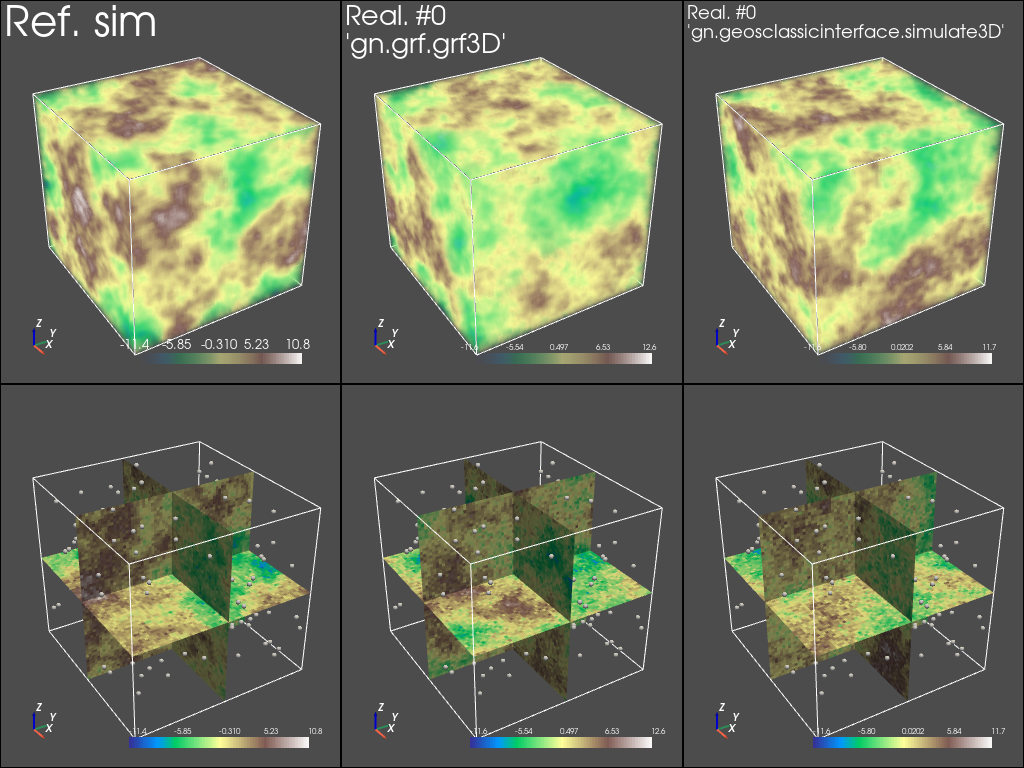

In [39]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(im_ref, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':''}, 
                                    # distinct title in each subplot for correct display!
                                text="Ref. sim") # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(im_sim_grf, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':' '}, 
                                    # distinct title in each subplot for correct display!
                                text="Real. #0\n'gn.grf.grf3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(im_sim_gci, iv=0, plotter=pp, cmap='terrain',
                                scalar_bar_kwargs={'title':'  '}, 
                                    # distinct title in each subplot for correct display!
                                text="Real. #0\n'gn.geosclassicinterface.simulate3D'", # title
                                text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(im_ref, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'   '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(im_sim_grf, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'    '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(im_sim_gci, iv=0, plotter=pp, cmap='terrain',
                               slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                               slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                               slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                               scalar_bar_kwargs={'title':'     '}, 
                                    # distinct title in each subplot for correct display!
                               text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified